In [1]:
import matplotlib.pyplot as plt
import pandas

countries_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"
cases_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

countries = pandas.read_csv(countries_csv)
cases = pandas.read_csv(cases_csv)
cases = cases[~cases["Province/State"].isin(["Recovered", "Diamond Princess", "Grand Princess"])].groupby("Country/Region").sum()
deaths = pandas.read_csv(deaths_csv)
deaths = deaths[~deaths["Province/State"].isin(["Recovered", "Diamond Princess", "Grand Princess"])].groupby("Country/Region").sum()

In [2]:
last_col_name = cases.columns[-1]

cases_ch = cases.loc["Switzerland"]
num_cases_ch = cases_ch[last_col_name]
cases_interest = cases[cases[last_col_name] >= int(num_cases_ch)]
cases_interest = cases_interest.sort_values(by=last_col_name, ascending=False)#.set_index("Country/Region")

deaths_interest = deaths.sort_values(by=last_col_name, ascending=False).iloc[:20, :]

In [3]:
# Show stats for this number of days, or None for all
num_days = 20

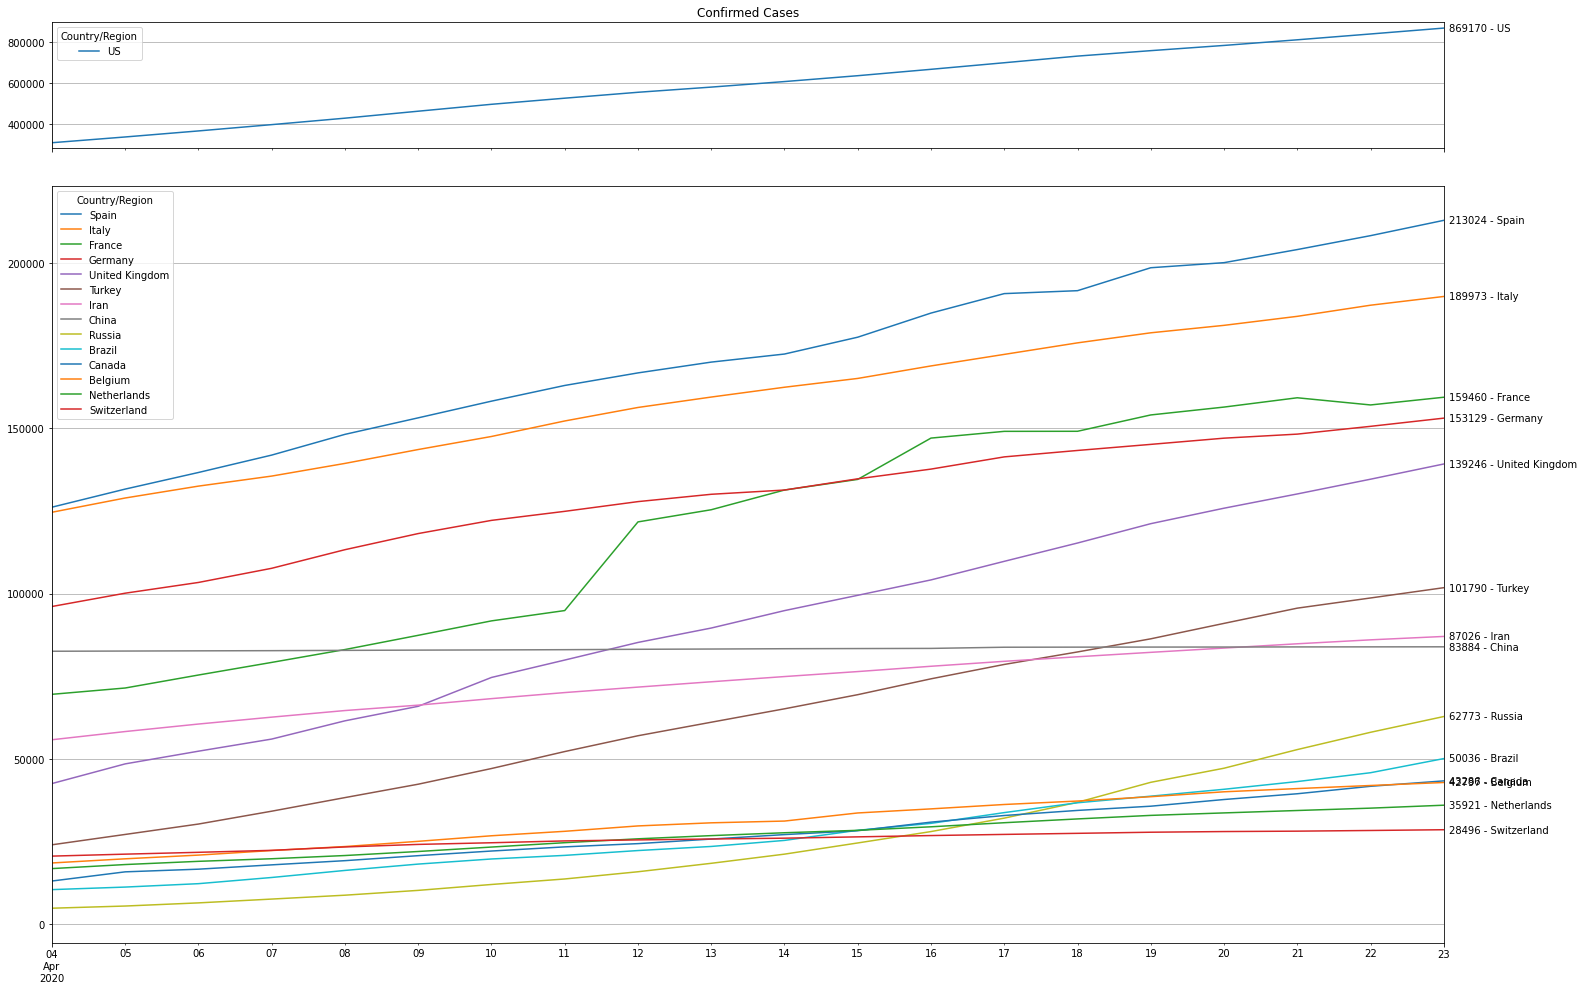

In [4]:
cases_trim = cases_interest.T.iloc[3:, :]

if num_days:
    cases_trim = cases_trim.iloc[-num_days:, :]

cases_trim.index = pandas.to_datetime(cases_trim.index)

fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [1, 6]})
fig.tight_layout(h_pad=0)
cases_plotUS = cases_trim.iloc[:, :1].plot(title="Confirmed Cases", figsize=(22, 15), grid=True, ax=axes[0])
cases_plotROW = cases_trim.iloc[:, 1:].plot(grid=True, ax=axes[1])

last_row = cases_trim.iloc[-1:, :]
plot = cases_plotUS
for k, v in last_row.items():
    plot.annotate("%d - %s" % (v[0], v.name), (last_row.index[0], v[0]), xytext=(5, -3), textcoords="offset points")
    plot = cases_plotROW


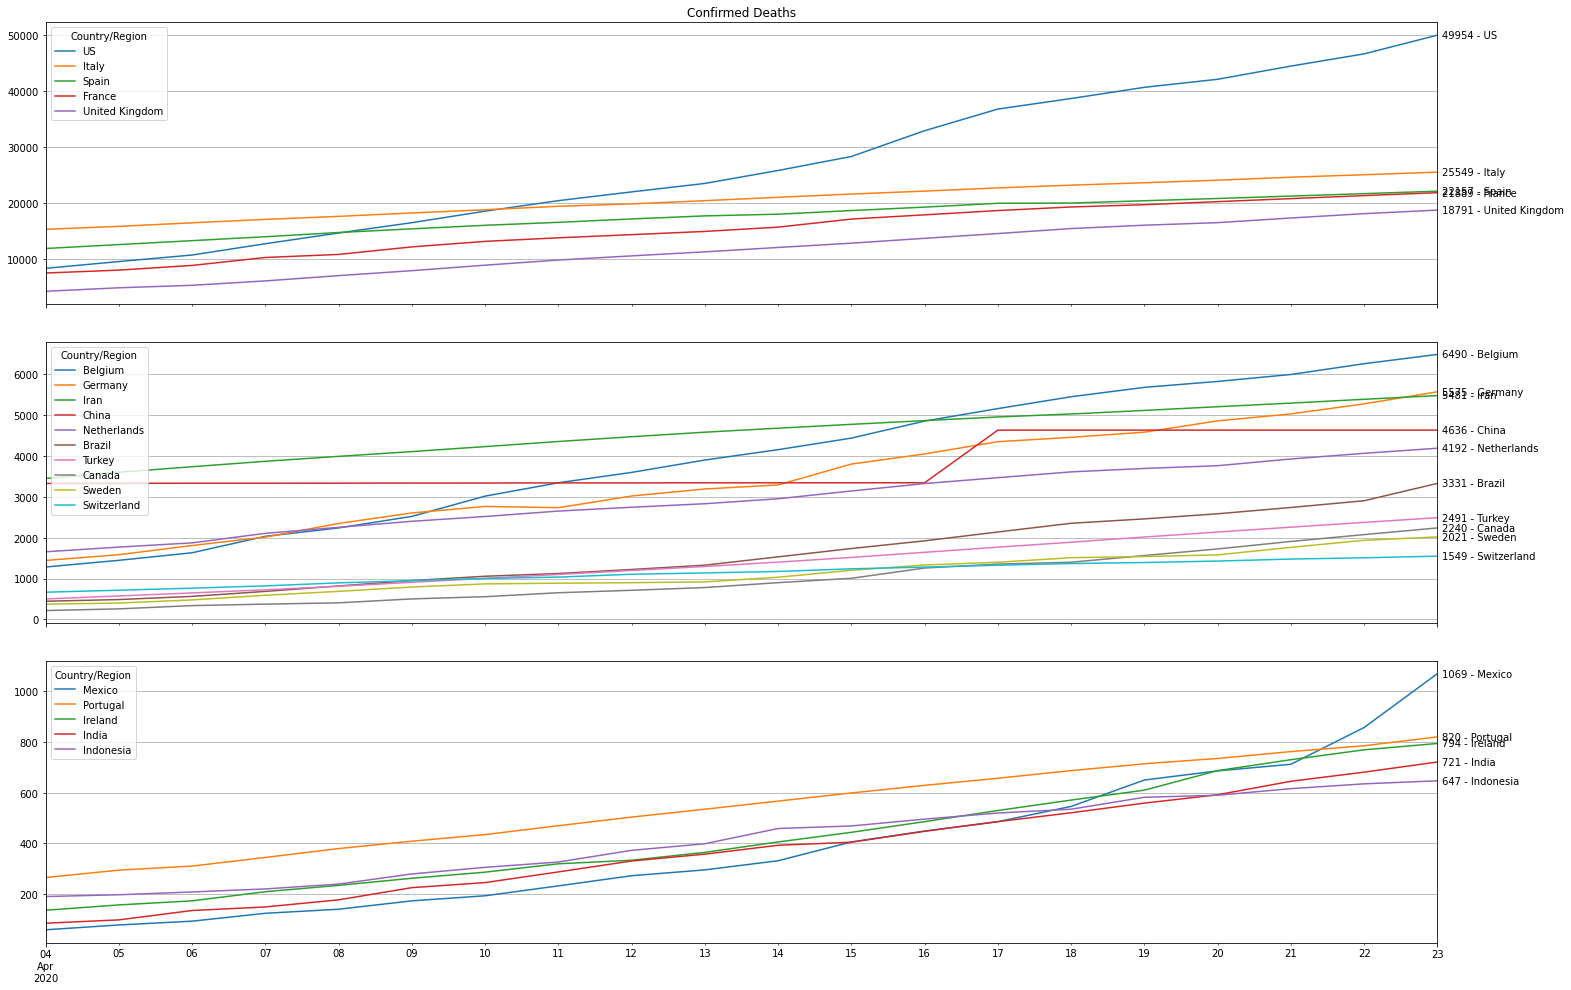

In [5]:
deaths_trim = deaths_interest.T.iloc[3:, :]

if num_days:
    deaths_trim = deaths_trim.iloc[-num_days:, :]

deaths_trim.index = pandas.to_datetime(deaths_trim.index)

fig, axes = plt.subplots(3, 1, sharex=True) #, gridspec_kw={"height_ratios": [3, 3, 3]})
fig.tight_layout(h_pad=0)
deaths_plotUSEU = deaths_trim.iloc[:, :5].plot(title="Confirmed Deaths", figsize=(22, 15), grid=True, ax=axes[0])
deaths_plotEU = deaths_trim.iloc[:, 5:15].plot(grid=True, ax=axes[1])
deaths_plotROW = deaths_trim.iloc[:, 15:].plot(grid=True, ax=axes[2])

last_row = deaths_trim.iloc[-1:, :]
count = 0
for k, v in last_row.items():
    if count < 5:
        plot = deaths_plotUSEU
    elif count < 15:
        plot = deaths_plotEU
    else:
        plot = deaths_plotROW
    plot.annotate("%d - %s" % (v[0], v.name), (last_row.index[0], v[0]), xytext=(5, -3), textcoords="offset points")
    count += 1


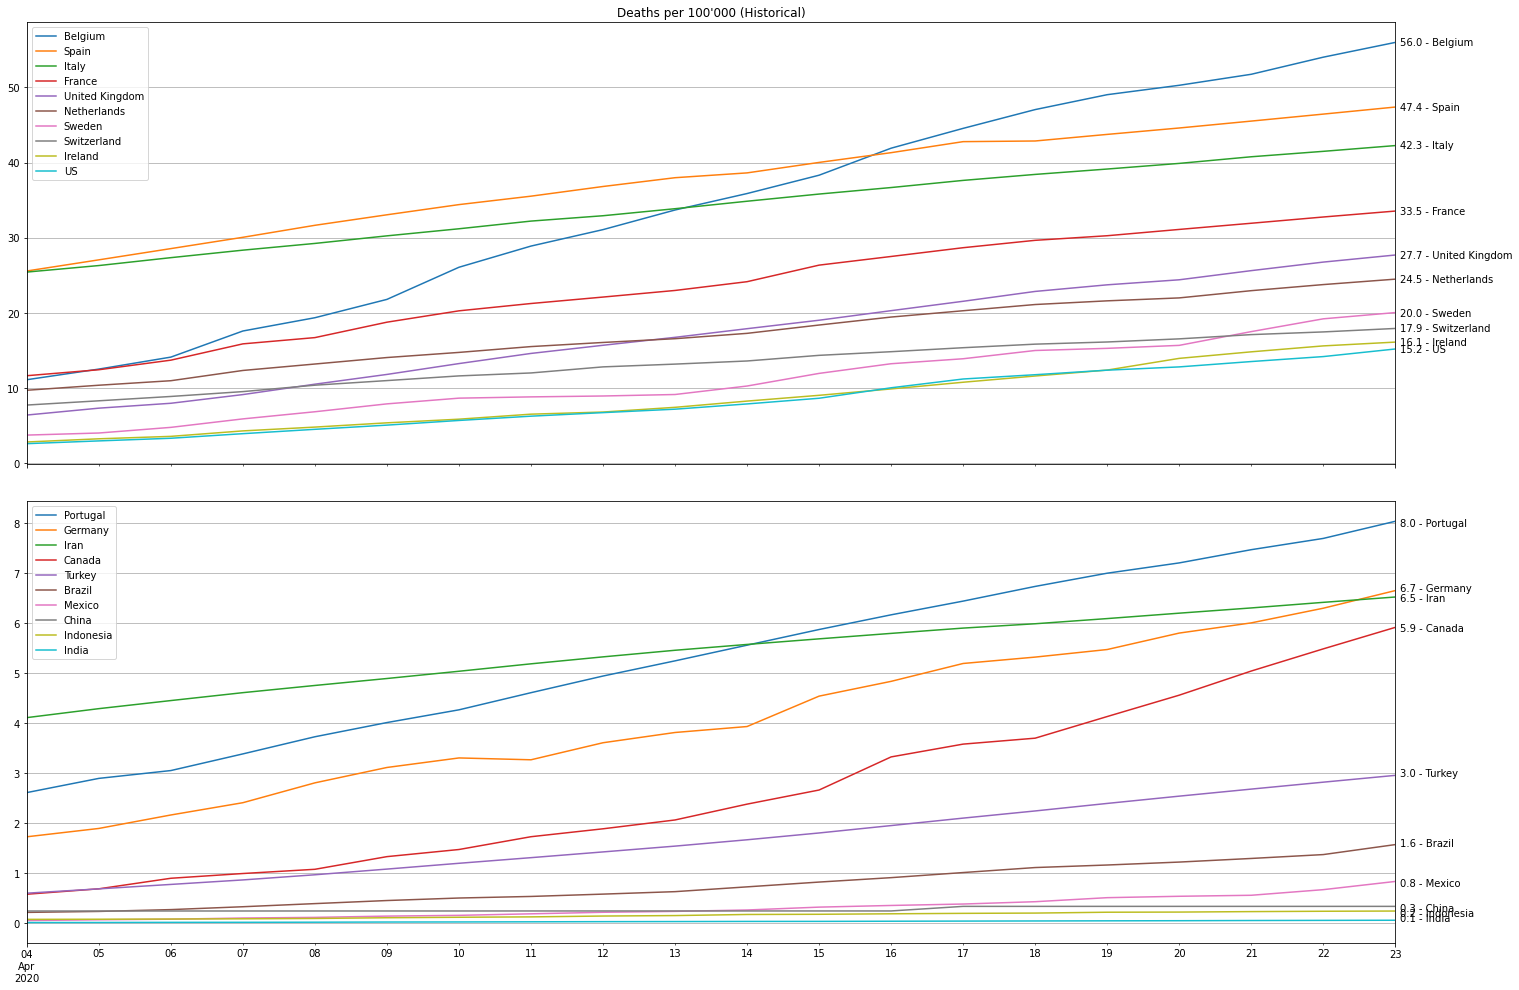

In [6]:
dpm = pandas.DataFrame()

for k, v in deaths_trim.items():
    pop = int(countries[countries["Combined_Key"] == k]["Population"])
    factor = 100000 / pop 
    series = v.mul(factor)
    dpm = dpm.append(series)

dpm = dpm.sort_values(by=last_col_name, ascending=False).T

fig, axes = plt.subplots(2, 1, sharex=True)#, gridspec_kw={"height_ratios": [2, 1]})
fig.tight_layout(h_pad=0)
dpm_plot1 = dpm.iloc[:, :10].plot(title="Deaths per 100'000 (Historical)", figsize=(22, 15), grid=True, ax=axes[0])
dpm_plot2 = dpm.iloc[:, 10:].plot(grid=True, ax=axes[1])

last_row = dpm.iloc[-1:, :]
last_row
count = 0
for k, v in last_row.items():
    if count < 10:
        plot = dpm_plot1
    else:
        plot = dpm_plot2
    val = round(v[0], 1)
    plot.annotate("%.1f - %s" % (val, v.name), (v.index[0], val), xytext=(5, -3), textcoords="offset points")
    count += 1

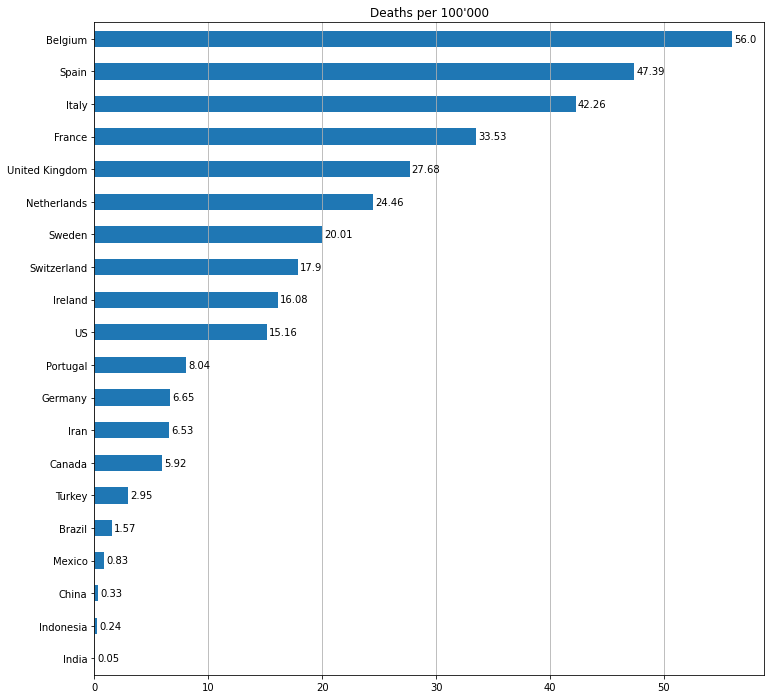

In [7]:
dpm_today = dpm.T.iloc[:, -1:].sort_values(by=last_col_name)
fig = dpm_today.plot.barh(title="Deaths per 100'000", figsize=(12, 12), legend=None)
fig.grid(axis="x")

i = 0
for k, v in dpm_today.iterrows():
    val = round(v[-1], 2)
    fig.annotate(val, (val, i), xytext=(2, -3), textcoords="offset points")
    i += 1